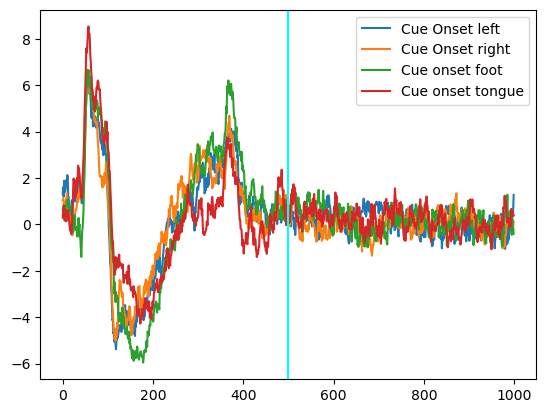

In [1]:
from keras.layers.reshaping.flatten import Flatten
from keras.layers.core.activation import Activation
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import regularizers
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [2]:
def data_prep(X,y,sub_sample,average,noise,period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]

    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_reshape = X.reshape(X.shape[0], X.shape[1], -1, sub_sample)
    X_max = np.max(X_reshape, axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    if noise:
      X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y
        
def data_finalize(period, total_number, takeout_sample, y_test=y_test): 
    ind_valid = np.random.choice(total_number, takeout_sample, replace=False)  # get 375 out of 2115 samples and no repetitation
    ind_train = np.array(list(set(range(total_number)).difference(set(ind_valid)))) # a set(unordered) different with another set, set = set1 - set2

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period=period)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period=period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period=period)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    return x_train, x_valid, x_test, y_train, y_valid, y_test



X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,noise=True, period=500)


# **Train the model on subject 1 data only and test it on both subject 1 test set and all subject test set**

In [3]:
# get subject 1 data for training and validation set
person_train_valid = person_train_valid.flatten()
X_train_valid=X_train_valid[np.where(person_train_valid==0)]
y_train_valid=y_train_valid[np.where(person_train_valid==0)]

In [4]:
print(X_train_valid.shape)


(237, 22, 1000)


In [5]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [6]:
period_accuracy={}
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=237, takeout_sample=42, period=1000, y_test=y_test)
# get subject 1 data for test set
person_test=person_test.flatten()
X_test_sub1 = x_test[np.where(person_test==0)]
y_test_sub1 = y_test[np.where(person_test==0)]
l2_lambda = 0.001
model_sub1 = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

  # Printing the model summary
model_sub1.summary()

  

model_sub1.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
model_sub1_results = model_sub1.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

val_acc = model_sub1_results.history['val_accuracy'][49]
period_accuracy['Sub1'] = val_acc
print(period_accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1, 26)        5174      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 167, 1, 26)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 167, 1, 26)       104       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 167, 1, 26)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 167, 1, 52)        12220     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 1, 52)        0

In [7]:
cnn_score = model_sub1.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.5199999809265137


In [8]:
# cnn_score = model_sub1.evaluate(x_test, y_test, verbose=0)
# print('Test accuracy of the basic CNN model:',cnn_score[1])

In [9]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
y_train_valid -= 769
y_test -= 769

In [10]:
period_accuracy={}
for i in range(1000, 1100, 100):
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model_all_subs = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),
      
      # Conv. block 4
      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

  # Printing the model summary
    model_all_subs.summary()

  

    model_all_subs.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
    model_all_subs_results = model_all_subs.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 500, 1, 26)        5174      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 167, 1, 26)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 167, 1, 26)       104       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 167, 1, 26)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 167, 1, 52)        12220     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 1, 52)       

In [11]:
cnn_score = model_all_subs.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of model_all_subs on subject 1 data:',cnn_score[1])
# print(X_test_sub1.shape)
# print(y_test_sub1.shape)

Test accuracy of model_all_subs on subject 1 data: 0.5400000214576721


In [12]:
print(x_test.shape)
print(y_test.shape)
cnn_score = model_all_subs.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of model_all_subs on all data:',cnn_score[1])

(1772, 500, 1, 22)
(1772, 4)
Test accuracy of model_all_subs on all data: 0.6597065329551697


In [12]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
y_train_valid -= 769
y_test -= 769

In [13]:
short_time_train_scores = {}
short_time_test_scores = {}
for i in range(50, 450, 50):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 25, 1, 26)         5174      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 1, 26)         0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 9, 1, 26)         104       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 9, 1, 26)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 1, 52)          12220     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 1, 52)        

In [14]:
for i in range(450, 550, 50):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

    # Printing the model summary
    model.summary()

  

    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

    # Training and validating the model
    model_results = model.fit(x_train,
                  y_train,
                  batch_size=32,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)

    short_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 225, 1, 26)        5174      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 75, 1, 26)        0         
 g2D)                                                            
                                                                 
 batch_normalization_38 (Bat  (None, 75, 1, 26)        104       
 chNormalization)                                                
                                                                 
 dropout_38 (Dropout)        (None, 75, 1, 26)         0         
                                                                 
 conv2d_39 (Conv2D)          (None, 75, 1, 52)         12220     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 25, 1, 52)      

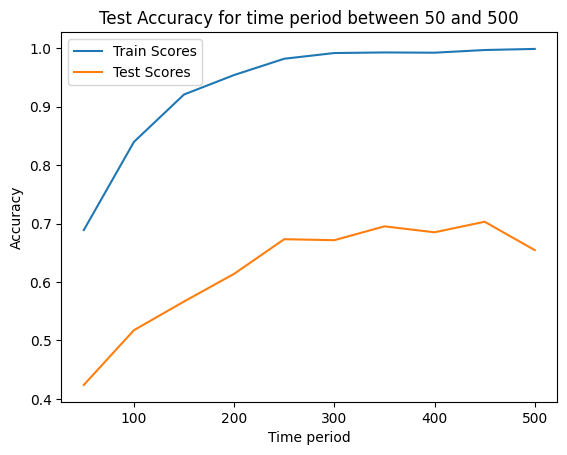

In [17]:
import matplotlib.pyplot as plt

# Create lists for x and y values
x_values = [int(k) for k in short_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in short_time_train_scores.values()]
test_scores = [v for v in short_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 50 and 500')
plt.legend()

# Show the plot
plt.show()

In [16]:
long_time_train_scores = {}
long_time_test_scores = {}
for i in range(600, 1100, 100):
    y_test = np.load("y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    l2_lambda = 0.001
    
    model = Sequential([

      # Conv. block 1
      keras.layers.Conv2D(filters=26, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(x_train.shape[1],1,22)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'), # Read the keras documentation
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 2
      keras.layers.Conv2D(filters=52, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      # Conv. block 3
      keras.layers.Conv2D(filters=104, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(filters=208, kernel_size=(9,1), padding='same', activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_lambda)),
      keras.layers.MaxPooling2D(pool_size=(3,1), padding='same'),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.5),


      # Output layer with Softmax activation
      keras.layers.Flatten(), # Flattens the input
      keras.layers.Dense(4, activation='softmax') # Output FC layer with softmax activation
  ])

  # Printing the model summary
    model.summary()
    
    model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
  

  # Training and validating the model
    model_results = model.fit(x_train,
              y_train,
              batch_size=32,
              epochs=epochs,
              validation_data=(x_valid, y_valid), verbose=True)

    long_time_train_scores[str(i)] = model.evaluate(x_train, y_train)[1]
    long_time_test_scores[str(i)] = model.evaluate(x_test, y_test)[1]
print(long_time_train_scores)
print(long_time_test_scores)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 300, 1, 26)        5174      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 100, 1, 26)       0         
 g2D)                                                            
                                                                 
 batch_normalization_50 (Bat  (None, 100, 1, 26)       104       
 chNormalization)                                                
                                                                 
 dropout_50 (Dropout)        (None, 100, 1, 26)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 100, 1, 52)        12220     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 34, 1, 52)      

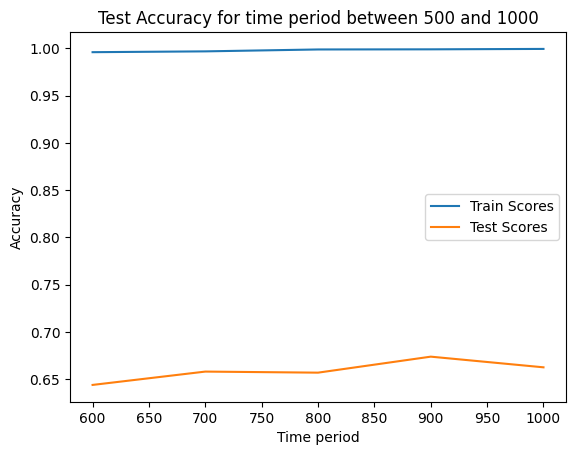

In [18]:
# Create lists for x and y values
x_values = [int(k) for k in long_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in long_time_train_scores.values()]
test_scores = [v for v in long_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 500 and 1000')
plt.legend()

# Show the plot
plt.show()

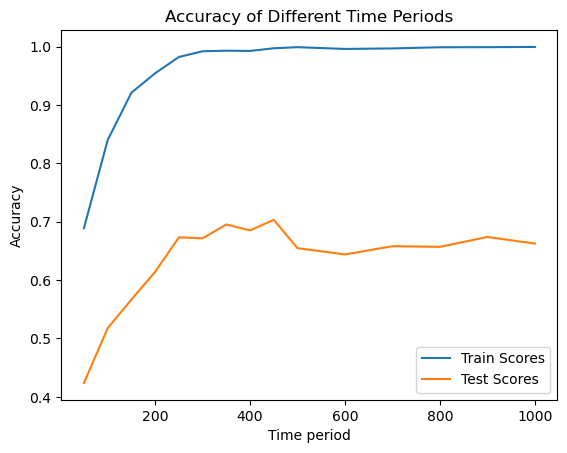

In [14]:
combined_train = {'50': 0.6889367699623108, '100': 0.8397988677024841, '150': 0.920976996421814, '200': 0.9543103575706482, '250': 0.9821839332580566, '300': 0.9919540286064148, '350': 0.9929597973823547, '400': 0.9925287365913391, '450': 0.9971264600753784, '500': 0.9989942312240601, '600': 0.995976984500885, '700': 0.9968391060829163, '800': 0.9988505840301514, '900': 0.9989942312240601, '1000': 0.9994252920150757}

combined_test = {'50': 0.42381489276885986, '100': 0.5174943804740906, '150': 0.5665914416313171, '200': 0.6139954924583435, '250': 0.6732505559921265, '300': 0.6715575456619263, '350': 0.6952595710754395, '400': 0.6851015686988831, '450': 0.703160285949707, '500': 0.6546275615692139, '600': 0.6439051628112793, '700': 0.6580135226249695, '800': 0.6568848490715027, '900': 0.6738148927688599, '1000': 0.6625282168388367}
x_values = [int(k) for k in combined_train.keys()] # convert keys to integer values
train_scores = [v for v in combined_train.values()]
test_scores = [v for v in combined_test.values()]
# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Time Periods')
plt.legend()

# Show the plot
plt.show()